## 6 - DSR with a heat pump 

This notebook models and analyses the impact on grid import and electricity cost of flexing heat pump load via altering the set point temperature during cheapest N time intervals in a day. It also illustrates use of an alternative controller which may have been harder to implement with the 'plan' based controller.

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
import os
current = os.path.abspath('')
parent = os.path.dirname(current)
sys.path.append(parent)

In [7]:
import importlib
import electrichouse as eh
from electrichouse.controllers import  HeatPumpDSRController

from datetime import datetime,tzinfo,timezone,timedelta
import pandas as pd
importlib.reload(eh)

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Setup controller

Evaluate the results of the model run on a grid of setpoint temperature vs number of DSR intervals (that is - number of times a day the setpoint is reduced - in this case these use the cheapest times per agile tariff).

In [8]:
results_z=[]
n_dsr_intervals_int=[]
for n_dsr_intervals in range(0,12,1):
    total_grid_cost_int=[]
    room_setpoint_temperature_flex_C_int=[]
    for two_x_room_setpoint_temperature_flex_C in range(32,40,1):
        room_setpoint_temperature_flex_C=two_x_room_setpoint_temperature_flex_C/2.
        controller =  HeatPumpDSRController(
                time_interval=timedelta(minutes=30),
                start_time=datetime(year=2021, month=1, day=1, tzinfo=timezone.utc),
                end_time=datetime(year=2022, month=1, day=1, tzinfo=timezone.utc),
                input_params={
                    "room_setpoint_temperature_C":20.,
                    "room_setpoint_temperature_flex_C":room_setpoint_temperature_flex_C,
                    "n_dsr_intervals":n_dsr_intervals,
                },
                control_params_init={},
            )

        output=[]
        for res in controller:
            output.append(res)
        outputd=pd.DataFrame.from_records(output,index='timestamp')
        total_grid_cost=(outputd["supplied_kW"]/2).dot(outputd["grid_import_price_pounds_per_kWh"]/2)
        total_grid_cost_int.append(total_grid_cost)
        room_setpoint_temperature_flex_C_int.append(room_setpoint_temperature_flex_C)
        
    n_dsr_intervals_int.append(n_dsr_intervals)
    results_z.append(total_grid_cost_int)
    
results_x=n_dsr_intervals_int
results_y=room_setpoint_temperature_flex_C_int

The following contour surface plot shows the relationship between the parameters and the cost of electricity. 

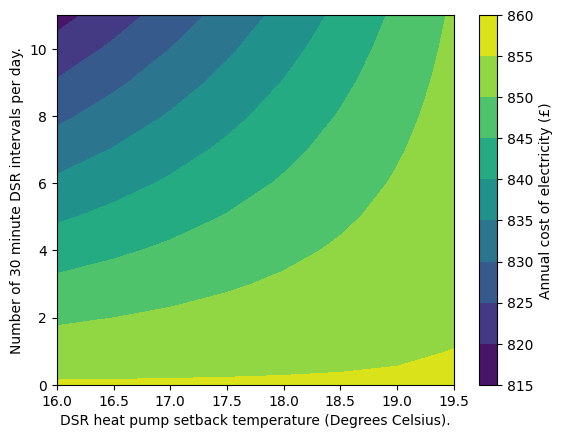

In [9]:
plt.contourf(results_y,results_x,results_z)
cbar=plt.colorbar()
cbar.set_label("Annual cost of electricity (£)")
plt.xlabel("DSR heat pump setback temperature (Degrees Celsius).")
plt.ylabel("Number of 30 minute DSR intervals per day.")
plt.show()